<a href="https://colab.research.google.com/github/pradyumna4998/Intro-to-ML/blob/main/HW7_Q2_Intro_to_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: V.pradyumna

student Id: 801345963

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 96.4 μs (started: 2024-12-05 22:17:54 -05:00)


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)
np.random.seed(123)

time: 1.8 s (started: 2024-12-05 22:17:54 -05:00)


In [ ]:
 # Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

time: 2.8 ms (started: 2024-12-05 22:17:55 -05:00)


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

time: 438 μs (started: 2024-12-05 22:17:55 -05:00)


In [ ]:
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and standard(std)
images = torch.stack([img_t for img_t, _ in training_dataset], dim=3)
mean = images.view(3, -1).mean(dim=1)
std = images.view(3, -1).std(dim=1)

Files already downloaded and verified
time: 2.63 s (started: 2024-12-05 22:17:55 -05:00)


In [ ]:
mean

tensor([0.4914, 0.4822, 0.4465])

time: 5.15 ms (started: 2024-12-05 22:17:58 -05:00)


In [ ]:
std

tensor([0.2470, 0.2435, 0.2616])

time: 3.61 ms (started: 2024-12-05 22:17:58 -05:00)


In [ ]:
cifar10 = datasets.CIFAR10(
    './data', train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

time: 373 ms (started: 2024-12-05 22:17:58 -05:00)


In [ ]:
cifar10_val = datasets.CIFAR10(
     './data', train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ]))

time: 328 ms (started: 2024-12-05 22:17:58 -05:00)


In [ ]:
training_loader = DataLoader(cifar10, batch_size=32, shuffle=True, num_workers=2)
testing_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False, num_workers=2)

time: 383 μs (started: 2024-12-05 22:17:59 -05:00)


In [ ]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

time: 176 μs (started: 2024-12-05 22:17:59 -05:00)


In [ ]:
print(torch.__version__)

2.5.1
time: 130 μs (started: 2024-12-05 22:17:59 -05:00)


In [ ]:

import datetime
def training_loop(epochs, optimizer, model, loss_function, training_loader):
    for epoch in range(1, epochs + 1):
        training_loss = 0.0
        for images, labels in training_loader:
            images = images.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(images)
            loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            training_loss += loss.item()

        if epoch == 1 or epoch % 2 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                training_loss / len(training_loader)))



time: 1.06 ms (started: 2024-12-05 22:17:59 -05:00)


In [ ]:
class Residual_Block(nn.Module):
    def __init__(self, n_chans):
        super(Residual_Block, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

time: 1.7 ms (started: 2024-12-05 22:17:59 -05:00)


In [ ]:

import torch.nn.functional as F
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [Residual_Block(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

time: 593 μs (started: 2024-12-05 22:17:59 -05:00)


In [ ]:
device

device(type='cpu')

time: 2.14 ms (started: 2024-12-05 22:17:59 -05:00)


In [ ]:
model = NetResDeep(n_chans1=32, n_blocks=10).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()
training_loop(
    epochs = 200,
    optimizer = optimizer,
    model = model,
    loss_function = loss_fn,
    training_loader = training_loader,
)

2024-12-05 22:19:35.447654 Epoch 1, Training loss 1.580204714015746
2024-12-05 22:21:19.120756 Epoch 2, Training loss 1.2759407428084317
2024-12-05 22:24:42.954484 Epoch 4, Training loss 1.069437035595997
2024-12-05 22:28:14.340506 Epoch 6, Training loss 0.9455082878155809
2024-12-05 22:31:47.269249 Epoch 8, Training loss 0.8655828677227462
2024-12-05 22:35:29.860798 Epoch 10, Training loss 0.8056326306598429
2024-12-05 22:39:26.714407 Epoch 12, Training loss 0.7557469299033294
2024-12-05 22:43:17.690768 Epoch 14, Training loss 0.7110495313916234
2024-12-05 22:47:32.716469 Epoch 16, Training loss 0.6728168770489751
2024-12-05 22:51:29.313126 Epoch 18, Training loss 0.6376248637091557
2024-12-05 22:55:33.683729 Epoch 20, Training loss 0.6002947187488535
2024-12-05 22:59:38.117036 Epoch 22, Training loss 0.5720548164707228
2024-12-05 23:03:37.925190 Epoch 24, Training loss 0.540243014759996
2024-12-05 23:07:40.123597 Epoch 26, Training loss 0.5118897078905591
2024-12-05 23:11:43.410048 E

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,
                                         shuffle=False)
def validate(model, train_loader, val_loader):
    acc_dict = {}
    predictions = []
    exp_labels = []

    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

                predictions.extend(predicted.cpu().numpy())
                exp_labels.extend(labels.cpu().numpy())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        acc_dict[name] = correct / total
    return acc_dict, predictions, exp_labels

time: 6.05 ms (started: 2024-12-06 04:43:20 -05:00)


In [ ]:
accuracy, predictions, expected_labels = validate(model, train_loader, val_loader)

Accuracy train: 0.99
Accuracy val: 0.66
time: 33.2 s (started: 2024-12-06 04:43:20 -05:00)


In [ ]:
print(classification_report(predictions, expected_labels, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.93      0.94      0.94      5911
  automobile       0.96      0.96      0.96      6023
        bird       0.92      0.91      0.92      6053
         cat       0.91      0.87      0.89      6246
        deer       0.92      0.94      0.93      5924
         dog       0.89      0.94      0.92      5710
        frog       0.94      0.96      0.95      5925
       horse       0.95      0.95      0.95      6004
        ship       0.97      0.92      0.95      6320
       truck       0.95      0.96      0.95      5884

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000

time: 118 ms (started: 2024-12-06 04:43:54 -05:00)


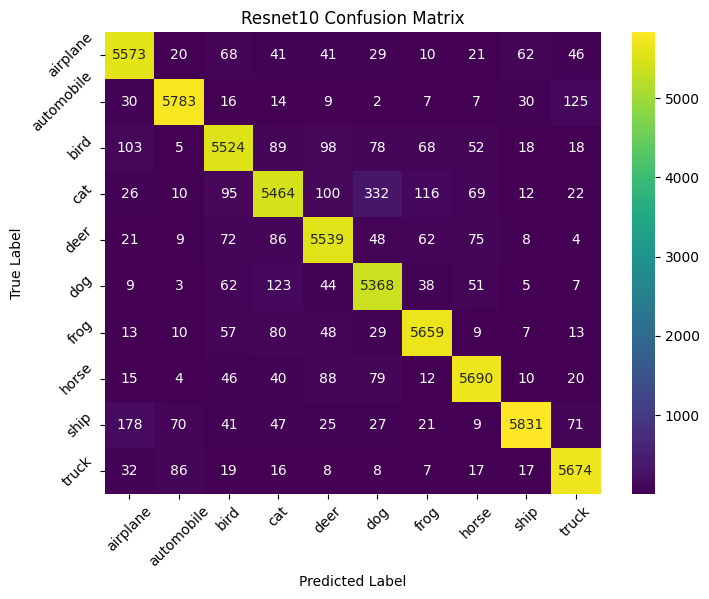

time: 321 ms (started: 2024-12-06 04:43:54 -05:00)


In [ ]:
precision = precision_score(predictions, expected_labels, average='macro')
recall = recall_score(predictions, expected_labels, average='macro')
cnf_matrix = confusion_matrix(predictions, expected_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cnf_matrix, annot=True, cmap="viridis", fmt='g',
            xticklabels = class_names, yticklabels = class_names)
plt.title('Resnet10 Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=45)

plt.show()